# Coursework 1: Convolutional Neural Networks
### Autograding
Part 1 of this coursework is autograded. This notebook comes with embedded tests which will verify that your implementations provide outputs with the appropriate types and shapes required for our hidden tests. You can run these same public tests through [LabTS](https://teaching.doc.ic.ac.uk/labts) when you have finished your work, to check that we get the same results when running these public tests.

Hidden tests will be ran after the submission deadline, and cannot be accessed :)

### Setting up working environment

For this coursework you will need to train a large network, therefore we recommend you work with Google Colaboratory or Lab cluster, where you can access GPUs.

Please refer to the Intro lecture for getting set up on the various GPU options.

**To run the public tests within colab** you will need to copy the "tests" folder to the /content/ directory (this is the default working directory - you can also change directories with %cd). You may also need to place a copy of the CW ipynb in the /content/ directory. A better option is to mount colab on gdrive and keep the files there (so you only need to do the set up once).

#### Setup
You will need to install pytorch and other libraries by running the following cell:

<font color="orange">**The deadline for submission is Tuesday, 6 Feb by 6 pm** </font>

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [65]:
!pip install -q otter-grader pandoc torch torchvision scikit-learn seaborn

In [93]:
# Initialization Cell
try:
    #WORKING_ENV = 'COLAB' # Can be LABS, COLAB, PAPERSPACE, SAGEMAKER
    WORKING_ENV = 'PAPERSPACE'
    USERNAME = 'your_username' # If working on Lab Machines - Your college username
    assert WORKING_ENV in ['LABS', 'COLAB', 'PAPERSPACE', 'SAGEMAKER']

    if WORKING_ENV == 'COLAB':
        from google.colab import drive
        %load_ext google.colab.data_table
        #d1_cw1_repo_path = 'Lectureship/CW/dl_cw1/' # path in your gdrive to the repo

        d1_cw1_repo_path='dl/cw1'
        content_path = f'/content/drive/MyDrive/{d1_cw1_repo_path}/' # path to gitrepo in gdrive after mounting
        print("path:",content_path)
        drive.mount('/content/drive/') # Outputs will be saved in your google drive

    elif WORKING_ENV == 'LABS':
        #content_path = f'/vol/bitbucket/{USERNAME}/dl/dl_cw1/' # You may want to change this
        #content_path = f'/homes/pc1923/Desktop/dl-cw1-' # You may want to change this
        content_path = f'/vol/bitbucket/{USERNAME}/DL_CW_1_pc1923/'

        # Your python env and training data should be on bitbucket
        if 'vol' not in content_path:
            import warnings
            warnings.warn(
                'It is best to create a dir in /vol/bitbucket/ otherwise you will quickly run into memory issues'
            )

    elif WORKING_ENV == 'PAPERSPACE': # Using Paperspace
        # Paperspace does not properly render animated progress bars
        # Strongly recommend using the JupyterLab UI instead of theirs
        !pip install ipywidgets
        content_path = '/notebooks'

    elif WORKING_ENV == 'SAGEMAKER':
        content_path = '/home/studio-lab-user/sagemaker-studiolab-notebooks/'
    else:
        raise NotImplementedError()

    import otter
    import os
    if not os.path.exists(f'{content_path}tests'):
        raise ValueError('Cannot find the public tests folder')
    grader = otter.Notebook(
        f'{content_path}dl_cw_1.ipynb',
        tests_dir=f'{content_path}tests')
    import matplotlib.pyplot as plt # DO NOT use %matplotlib inline in the notebook
    import numpy as np
    rng_seed = 90
except:
    # This is a fallback initialization for running on LabTS. Please leave this in place before submission.
    import otter
    grader = otter.Notebook("dl_cw_1.ipynb")
    import matplotlib.pyplot as plt
    import numpy as np
    rng_seed = 90


## Introduction
In this courswork you will explore various deep learning functionalities through implementing a number of pytorch neural network operations/layers and creating your own deep learning model and methodology for a high dimensional classification problem.

#### Intended learning outcomes
- An understanding of the mechanics behind convolutional, pooling, linear and batch norm operations.
- Be able to implement convolution, pooling, linear and batch norm layers from basic building blocks.
- Experience designing, implementing and optimising a classifier for a high dimensional dataset.

## Part 1 (50 points)

In this part, you will use basic Pytorch operations to define the 2D convolution, 2D max pooling, linear layer, as well as 2D batch normalization operations. Being computer scientists we care about efficiency, we therefore do not want to see any _for loops_!

**Your Task**
- Implement the forward pass for Conv2D (15 points), MaxPool2D (15 points), Linear (5 points) and BatchNorm2d (15 points)
- You are **NOT** allowed to use the torch.nn modules (The one exception is that the class inherits from nn.Module)

_hint: check out F.unfold and F.fold, they may be helpful_

In [94]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class Conv2d(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride=1,
                 padding=0,
                 bias=True):

        super(Conv2d, self).__init__()
        """
        An implementation of a convolutional layer.

        The input consists of N data points, each with C channels, height H and
        width W. We convolve each input with F different filters, where each filter
        spans all C channels and has height H' and width W'.

        Parameters:
        - w: Filter weights of shape (F, C, H', W',)
        - b: Biases of shape (F,)
        - kernel_size: Union[int, (int, int)], Size of the convolving kernel
        - stride: Union[int, (int, int)], Number of pixels between adjacent receptive fields in the
            horizontal and vertical directions.
        - padding: Union[int, (int, int)], Number of pixels that will be used to zero-pad the input.
        """
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        # TODO: Define the parameters used in the forward pass
        # saving all the input variables into fields of the object


        # Do not initialize weights or biases with torch.empty() but rather use torch.zeros()
        # Weights should have shape [out_channels, in_channels, kernel_x, kernel_y]


        self.w = nn.Parameter(torch.rand((out_channels,in_channels,kernel_size,kernel_size,)))

        # self.w = nn.Parameter(torch.Tensor(out_channels, in_channels,
        #                                          kernel_size, kernel_size))
        # self.w.data.normal_(-0.1, 0.1)
        # self.w = nn.init.kaiming_normal(self.w)

        # Bias should have shape [out_channels]

        if not bias:
          self.b=None
        else:
          self.b = nn.Parameter(torch.rand((out_channels,)))

        self.C = in_channels
        self.F = out_channels # is the N
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        
        if isinstance(self.kernel_size,int):
            self.kernel_size_h=self.kernel_size
            self.kernel_size_w=self.kernel_size
        else:
            self.kernel_size_h, self.kernel_size_w = self.kernel_size
                   
        if isinstance(self.padding,int):
            self.padding_h=self.padding
            self.padding_w=self.padding
        else:
            self.padding_h, self.padding_w = self.kernel_size
            
        if isinstance(self.padding,int):
            self.stride_h=self.stride
            self.stride_w=self.stride
        else:
            self.stride_h, self.stride_w = self.stride_size
                 
       
        #...
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    def forward(self, x):
        """
        Input:
        - x: Input data of shape (N, C, H, W)
        Output:
        - out: Output data, of shape (N, F, H', W').
        """
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        # TODO: Implement the forward pass                                     #
        #print("shape 2: ",self.w.shape)
        N=x.shape[0]
        C=x.shape[1]
        H=x.shape[2]
        W=x.shape[3]
        # unfold returns [N, C * kernel_size * kernel_size, output_size]
        # the formula for the output size is the following
        
        #output_size = int((H - self.kernel_size + 2*self.padding)/self.stride) + 1
        
        output_size_h = int((H - self.kernel_size_h + 2*self.padding_h)/self.stride_h) + 1
        output_size_w = int((W - self.kernel_size_w + 2*self.padding_w)/self.stride_w) + 1

        input_unfolded=F.unfold(input=x,kernel_size=self.kernel_size,  dilation=1,padding=self.padding, stride=self.stride)
        
        
        output_unfolded=input_unfolded.transpose(1, 2) @ self.w.view(self.F, -1).transpose(1, 0)
        

        # why this does not stand? if it does not have a bias then it will be zero
        if self.b is not None:
          output_unfolded=output_unfolded+ self.b

        out = output_unfolded.transpose(1,2).view( N, self.F, output_size_h, output_size_w)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        return out

In [95]:
grader.check("Convolution Layer")

Convolution Layer results: All test cases passed!
Convolution Layer - 1 message: Shape Test Passed
Convolution Layer - 2 message: Type Test Passed
Convolution Layer - 3 message: Param Name Test Passed
Convolution Layer - 4 message: Param Shape Test Passed

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MaxPool2d(nn.Module):
    def __init__(self, kernel_size):
        super(MaxPool2d, self).__init__()
        """
        An implementation of a max-pooling layer.

        Parameters:
        - kernel_size: Union[int, (int, int)], the size of the window to take a max over
        """
        # TODO: Define the parameters used in the forward pass                 #
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        self.kernel_size = kernel_size
        if isinstance(self.kernel_size,int):
            self.kernel_size_h=self.kernel_size
            self.kernel_size_w=self.kernel_size
        else:
            self.kernel_size_h, self.kernel_size_w = self.kernel_size


        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    def forward(self, x):
        """
        Input:
        - x: Input data of shape (N, C, H, W)
        Output:
        - out: Output data, of shape (N, C, H', W').
        """
        # TODO: Implement the forward pass                                     #
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        # F.unfold(input, kernel_size, dilation=1, padding=0, stride=1)
        
        out= torch.max( F.unfold(x, kernel_size=self.kernel_size, stride=self.kernel_size))

        N=x.shape[0]
        C=x.shape[1]
        H=x.shape[2]
        W=x.shape[3]
        #output_size = int((H - self.kernel_size)/self.kernel_size) + 1
        output_size_h = int((H - self.kernel_size_h)/self.kernel_size_h) + 1
        output_size_w = int((W - self.kernel_size_w)/self.kernel_size_w) + 1


        unfolded=F.unfold(input=x, kernel_size=self.kernel_size,stride=self.kernel_size).transpose(2, 1)
        unfolded=unfolded.view(N,-1,C,self.kernel_size_h * self.kernel_size_w).transpose(2,1)
        
        out = torch.max(unfolded,3)[0].view(N,C,output_size_h,output_size_w)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        return out


In [27]:
grader.check("MaxPool Layer")

MaxPool Layer results: All test cases passed!
MaxPool Layer - 1 message: Shape Test Passed
MaxPool Layer - 2 message: Type Test Passed

In [17]:
class Linear(nn.Module):
    def __init__(self, in_channels, out_channels, bias=True):
        super(Linear, self).__init__()
        """
        An implementation of a Linear layer.

        Parameters:
        - weight: the learnable weights of the module of shape (in_channels, out_channels).
        - bias: the learnable bias of the module of shape (out_channels).
        """
        # TODO: Define the parameters used in the forward pass                 #
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # self.register_parameter is not used as it was mentioned on piazza
        # that this will be overridden
        # Also no initialisation methods for this reason
        self.w = nn.Parameter(torch.rand((in_channels,out_channels,)))
        if not bias:
          self.b=None
        else:
          self.b = nn.Parameter(torch.rand((out_channels,)))

        #...
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    def forward(self, x):
        """
        Input:
        - x: Input data of shape (N, *, H) where * means any number of additional
        dimensions and H = in_channels
        Output:
        - out: Output data of shape (N, *, H') where * means any number of additional
        dimensions and H' = out_channels
        """
        # TODO: Implement the forward pass                                     #
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # This is just a linear layer so multiplicaiton with the weights and add the bias

        out=x @ self.w
        if self.b is not None:
          out=out+self.b

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        return out

In [18]:
grader.check("Linear Layer")

Linear Layer results: All test cases passed!
Linear Layer - 1 message: Shape Test Passed
Linear Layer - 2 message: Type Test Passed
Linear Layer - 3 message: Param Name Test Passed
Linear Layer - 4 message: Param Shape Test Passed

In [28]:
class BatchNorm2d(nn.Module):
	def __init__(self, num_features, eps=1e-05, momentum=0.1):
		super(BatchNorm2d, self).__init__()
		"""
		An implementation of a Batch Normalization over a mini-batch of 2D inputs.

		The mean and standard-deviation are calculated per-dimension over the
		mini-batches and gamma and beta are learnable parameter vectors of
		size num_features.

		Parameters:
		- num_features: C from an expected input of size (N, C, H, W).
		- eps: a value added to the denominator for numerical stability. Default: 1e-5
		- momentum: the value used for the running_mean and running_var
		computation. Default: 0.1 . (i.e. 1-momentum for running mean)
		- gamma: the learnable weights of shape (num_features).
		- beta: the learnable bias of the module of shape (num_features).
		"""
		# TODO: Define the parameters used in the forward pass                 #
		# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

		self.num_features = num_features
		self.eps = eps
		self.momentum = momentum

		# Initialize gamma and beta as learnable parameters
		self.gamma = nn.Parameter(torch.ones(num_features))
		self.beta = nn.Parameter(torch.zeros(num_features))

		# Initialize running mean and variance
        # first 1 is because i have 1 mean,var per channel across batch
        # the second 1,1 means buffer is not spatially extended
		self.register_buffer('running_mean', torch.zeros(1,num_features,1,1))
		self.register_buffer('running_var', torch.ones(1,num_features,1,1))


		#...
		# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

	def forward(self, x):
		"""
		During training this layer keeps running estimates of its computed mean and
		variance, which are then used for normalization during evaluation.
		Input:
		- x: Input data of shape (N, C, H, W)
		Output:
		- out: Output data of shape (N, C, H, W) (same shape as input)
		"""
		# TODO: Implement the forward pass                                     #
		#       (be aware of the difference for training and testing)          #
		# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
		#...

		if self.training:
			x_mean = x.mean((0, 2, 3), keepdim=True)
			x_var = ((x - x_mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
			self.running_mean = (1.0 - self.momentum) * self.running_mean + self.momentum * x_mean
			self.running_var = (1.0 - self.momentum) * self.running_var + self.momentum * x_var
			x_hat = (x-x_mean) / torch.sqrt(x_var + self.eps)
			x = self.gamma.view(1,self.num_features,1,1) * x_hat + self.beta.view(1,self.num_features,1,1)
		else:
			x_mean = self.running_mean
			x_var = self.running_var
			x_hat = (x - x_mean) / torch.sqrt(x_var + self.eps)
			x = self.gamma.view(1,self.num_features,1,1) * x_hat + self.beta.view(1,self.num_features,1,1)


		# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


		return x

In [29]:
grader.check("BatchNorm Layer")

BatchNorm Layer results: All test cases passed!
BatchNorm Layer - 1 message: Shape Test Passed
BatchNorm Layer - 2 message: Type Test Passed
BatchNorm Layer - 3 message: Param Name Test Passed
BatchNorm Layer - 4 message: Param Shape Test Passed

## Part 2 (40 points)

In this part, you will design, train and optimise a custom deep learning model for classifying a specially selected subset of Imagenet. Termed NaturalImageNet, it is made up of a hand selected subset of the famous ImageNet dataset. The dataset contains 20 classes, all animals from the natural world. We hope that this dataset will be fun to work with but also a challenge.

You will be marked on your experimental process, methods implemented and your reasoning behind your decisions. While there will be marks for exceeding a baseline performance score we stress that students should **NOT** spend excessive amounts of time optimising performance to silly levels.

We have given you some starter code, please feel free to use and adapt it.

**Your Task**
1. Develop/adapt a deep learning pipeline to maximise performance on the test set. (28 points)
    * 8 points will be awarded for improving on the baseline score on the test set. Don't worry you can get full marks here by improving by a minor amount.
    * 20 points will be awarded for the adaptations made to the baseline model and pipeline.

2. Answer the qualititative questions (12 points)

**Downloading NaturalImageNet**

In [68]:
ON_COLAB = False


In [34]:
ON_COLAB = False

!wget https://zenodo.org/record/5846979/files/NaturalImageNetTest.zip?download=1
!wget https://zenodo.org/record/5846979/files/NaturalImageNetTrain.zip?download=1
if ON_COLAB:
    !unzip /content/NaturalImageNetTest.zip?download=1 > /dev/null
    !unzip /content/NaturalImageNetTrain.zip?download=1 > /dev/null
else:
    !unzip NaturalImageNetTest.zip?download=1 > /dev/null
    !unzip NaturalImageNetTrain.zip?download=1 > /dev/null

--2024-01-30 20:06:46--  https://zenodo.org/record/5846979/files/NaturalImageNetTest.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.184.98.238, 188.185.79.172, 188.184.103.159, ...
Connecting to zenodo.org (zenodo.org)|188.184.98.238|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/5846979/files/NaturalImageNetTest.zip [following]
--2024-01-30 20:06:46--  https://zenodo.org/records/5846979/files/NaturalImageNetTest.zip
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 138507970 (132M) [application/octet-stream]
Saving to: ‘NaturalImageNetTest.zip?download=1.4’

       NaturalImage   3%[                    ]   5.05M  6.64MB/s               ^C
--2024-01-30 20:06:48--  https://zenodo.org/record/5846979/files/NaturalImageNetTrain.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.185.79.172, 188.184.98.238, 188.184.103.159, ...
Connecting to zenodo.org (zenodo.org)|188.185.7

In [69]:
#torch
import torch
from torch.nn import Conv2d, MaxPool2d
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
#other
import matplotlib.pyplot as plt
import numpy as np
# set the seed for reproducibility
rng_seed = 90
torch.manual_seed(rng_seed)

In [70]:
# When we import the images we want to first convert them to a tensor.
# It is also common in deep learning to normalise the the inputs. This
# helps with stability.
# To read more about this subject this article is a great one:
# https://towardsdatascience.com/understand-data-normalization-in-machine-learning-8ff3062101f0

# transforms is a useful pytorch package which contains a range of functions
# for preprocessing data, for example applying data augmentation to images
# (random rotations, blurring the image, randomly cropping the image). To find out
# more please refer to the pytorch documentation:
# https://pytorch.org/docs/stable/torchvision/transforms.html

mean = torch.Tensor([0.485, 0.456, 0.406])
std = torch.Tensor([0.229, 0.224, 0.225])
transform = transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(256),
            transforms.ToTensor(),
            transforms.Normalize(mean.tolist(), std.tolist()),
        ]
    )




train_path = ('/content/' if ON_COLAB else '') + 'NaturalImageNetTrain'
test_path = ('/content/' if ON_COLAB else '') +'NaturalImageNetTest'

train_dataset = datasets.ImageFolder(train_path, transform=transform)




test_dataset = datasets.ImageFolder(test_path, transform=transform)

# Create train val split
n = len(train_dataset)
n_val = int(n/10)

train_set, val_set = torch.utils.data.random_split(train_dataset, [n-n_val, n_val])


print(len(train_set), len(val_set), len(test_dataset))


# The number of images to process in one go. If you run out of GPU
# memory reduce this number!
batch_size = 128

# Dataloaders are a great pytorch functionality for feeding data into our AI models.
# see https://pytorch.org/docs/stable/data.html?highlight=dataloader#torch.utils.data.DataLoader
# for more info.

loader_train = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
loader_val = DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=2)
loader_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

17986 1998 2000


In [71]:
unnormalize = transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())

def denorm(x):
    '''
    Function to reverse the normalization so that we can visualise the outputs
    '''
    x = unnormalize(x)
    x = x.view(x.size(0), 3, 256, 256)
    return x

def show(img):
    '''
    function to visualise tensors
    '''
    if torch.cuda.is_available():
        img = img.cpu()
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)).clip(0, 1))

**Visualising some example images**

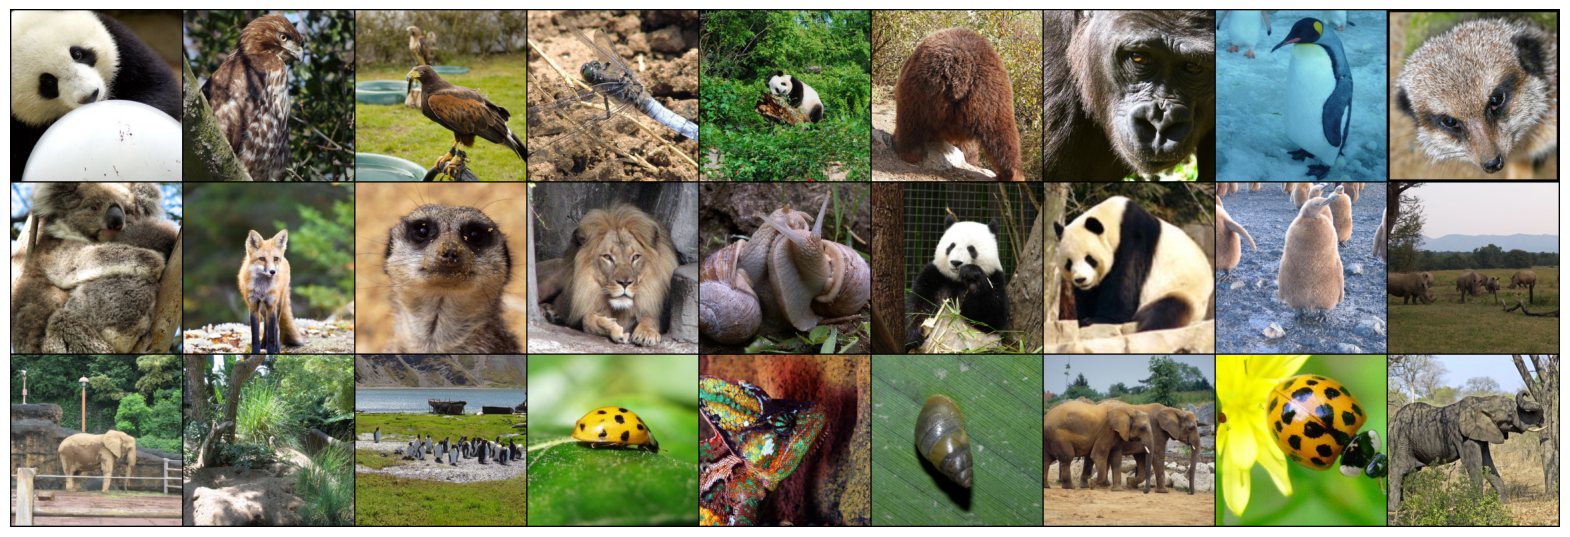

In [72]:
sample_inputs, _ = next(iter(loader_val))
fixed_input = sample_inputs[:27, :, :, :]

img = make_grid(denorm(fixed_input), nrow=9, padding=2, normalize=False,
                value_range=None, scale_each=False, pad_value=0)
plt.figure(figsize=(20,10))
plt.axis('off')
show(img)

Next, we define ResNet-18:

In [73]:
# define resnet building blocks

class ResidualBlock(nn.Module):
    def __init__(self, inchannel, outchannel, stride=1):

        super(ResidualBlock, self).__init__()
        
        # original Residual Block
        self.left = nn.Sequential(Conv2d(inchannel, outchannel, kernel_size=3,
                                         stride=stride, padding=1, bias=False),
                                  nn.BatchNorm2d(outchannel),
                                  nn.ReLU(inplace=True),
                                  Conv2d(outchannel, outchannel, kernel_size=3,
                                         stride=1, padding=1, bias=False),
                                  nn.BatchNorm2d(outchannel))
        
        
        # Pre-activation Residual block
        # self.left = nn.Sequential(nn.BatchNorm2d(inchannel),
        #                           nn.ReLU(inplace=True),
        #                           Conv2d(inchannel, outchannel, kernel_size=3,
        #                                  stride=stride, padding=1, bias=False),
        #                           nn.BatchNorm2d(outchannel),
        #                           nn.ReLU(inplace=True),
        #                           Conv2d(outchannel, outchannel, kernel_size=3,
        #                                  stride=1, padding=1, bias=False)
        #                          )
        
        # original Residual block with bias
        # self.left = nn.Sequential(Conv2d(inchannel, outchannel, kernel_size=3,
        #                                  stride=stride, padding=1, bias=True),
        #                           nn.BatchNorm2d(outchannel),
        #                           nn.ReLU(inplace=True),
        #                           Conv2d(outchannel, outchannel, kernel_size=3,
        #                                  stride=1, padding=1, bias=True),
        #                           nn.BatchNorm2d(outchannel))
       
        # Original Residual block
        # self.left = nn.Sequential(Conv2d(inchannel, outchannel, kernel_size=3,
        #                                  stride=stride, padding=1, bias=False),
        #                           nn.BatchNorm2d(outchannel),
        #                           nn.ReLU(inplace=True),
        #                           Conv2d(outchannel, outchannel, kernel_size=3,
        #                                  stride=1, padding=1, bias=False),
        #                           nn.BatchNorm2d(outchannel))
    


        self.shortcut = nn.Sequential()

        if stride != 1 or inchannel != outchannel:

            self.shortcut = nn.Sequential(Conv2d(inchannel, outchannel,
                                                 kernel_size=1, stride=stride,
                                                 padding = 0, bias=False),
                                          nn.BatchNorm2d(outchannel) )

    def forward(self, x):

        out = self.left(x)

        out += self.shortcut(x)

        out = F.relu(out)

        return out



# define resnet

class ResNet(nn.Module):

    def __init__(self, ResidualBlock, num_classes = 20):

        super(ResNet, self).__init__()

        self.inchannel = 16
        # Original ResNet 18 , first convolution of the network
        # self.conv1 = nn.Sequential(Conv2d(3, 16, kernel_size = 3, stride = 1,
        #                                     padding = 1, bias = False),
        #                           nn.BatchNorm2d(16),
        #                           nn.ReLU())
        
        
        # ResNet 18(first convolution) with bigger kernel (size 5 instead of 3, and added padding to note lose a lot of data)
        # self.conv1 = nn.Sequential(Conv2d(3, 16, kernel_size = 5, stride = 1,
        #                                     padding = 2, bias = False),
        #                           nn.BatchNorm2d(16),
        #                           nn.ReLU())

        # ResNet 18 (first convolution) with bigger kernel(size=5) and with MaxPooling after the Relu
        self.conv1 = nn.Sequential(Conv2d(3, 16, kernel_size = 5, stride = 1,
                                            padding = 2, bias = False),
                                  nn.BatchNorm2d(16),
                                  nn.ReLU(),
                                nn.MaxPool2d(kernel_size=5, stride=1, padding=2)
                                  )
    
        
        self.layer1 = self.make_layer(ResidualBlock, 16, 2, stride = 2)
        self.layer2 = self.make_layer(ResidualBlock, 32, 2, stride = 2)
        self.layer3 = self.make_layer(ResidualBlock, 64, 2, stride = 2)
        self.layer4 = self.make_layer(ResidualBlock, 128, 2, stride = 2)
        self.layer5 = self.make_layer(ResidualBlock, 256, 2, stride = 2)
        self.layer6 = self.make_layer(ResidualBlock, 512, 2, stride = 2)
        
        self.maxpool = MaxPool2d(4)
        self.fc = nn.Linear(512, num_classes)


    def make_layer(self, block, channels, num_blocks, stride):

        strides = [stride] + [1] * (num_blocks - 1)

        layers = []

        for stride in strides:

            layers.append(block(self.inchannel, channels, stride))

            self.inchannel = channels

        return nn.Sequential(*layers)


    def forward(self, x):

        x = self.conv1(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# please do not change the name of this class
def MyResNet():
    return ResNet(ResidualBlock)

In [78]:
################# ResNet 34 ##############
# All this cell is for the ResNet 34 network
# The original/first resnet 34 is as explained in the question
# I use the residual block from the cell above, as both resnets use the same residual block.



class ResNet(nn.Module):
    def __init__(self, ResidualBlock, num_classes=20):
        super(ResNet, self).__init__()

        self.inchannel = 64  # Start with 64 channels for ResNet-34

        # Original first convolutional layer,with size=7, stride=2,padding=3 and without bias.
        # i also start with 64 output channels as this can help the network help better.
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        # First convolutional layer without MaxPooling
        # self.conv1 = nn.Sequential(
        #     nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
        #     nn.BatchNorm2d(64),
        #     nn.ReLU()
        # )
        
        # First convolutional layer like the original but with smaller kernel size (3 instead of 7)
        # self.conv1 = nn.Sequential(
        #     nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1, bias=False),
        #     nn.BatchNorm2d(64),
        #     nn.ReLU(),
        #     nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        # )
        
        
        # Residual layers
        # input,number of convlotution
        self.layer1 = self.make_layer(ResidualBlock, 64, 3, stride=1)
        self.layer2 = self.make_layer(ResidualBlock, 128, 4, stride=2)
        self.layer3 = self.make_layer(ResidualBlock, 256, 6, stride=2)
        
        self.layer4 = self.make_layer(ResidualBlock, 512, 3, stride=2)
        
        # Tried to add more layers, added 5 layers instead of 3
        #self.layer5 = self.make_layer(ResidualBlock, 1024, 3, stride=2)


        # Global average pooling
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # Fully connected layer --- Inital runs -4 layers
        self.fc = nn.Linear(512, num_classes)
        
        # For the ResNet34 with 5 layers 
        #self.fc = nn.Linear(1024, num_classes)
        
        # For the ResNet34 with 3 layers 
        #self.fc = nn.Linear(256, num_classes)


    def make_layer(self, block, channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []

        for stride in strides:
            layers.append(block(self.inchannel, channels, stride))
            self.inchannel = channels

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        # Adding the 5th layer in the ResNet34
        #x=self.layer5(x)
        
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# ResidualBlock remains the same as in your original code

# Function to create ResNet-34
def MyResNet34():
    return ResNet(ResidualBlock, num_classes=20)

In [79]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


def confusion(preds, y):
  labels = ['African Elephant', 'Kingfisher', 'Deer','Brown Bear', 'Chameleon', 'Dragonfly',
    'Giant Panda', 'Gorilla', 'Hawk', 'King Penguin', 'Koala', 'Ladybug', 'Lion',
    'Meerkat', 'Orangutan', 'Peacock', 'Red Fox', 'Snail', 'Tiger', 'White Rhino']
  # Plotting the confusion matrix
  cm = confusion_matrix(y.cpu().numpy(), preds.cpu().numpy(), normalize='true')
  fig, ax= plt.subplots(1, 1, figsize=(15,10))
  sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

  # labels, title and ticks
  ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
  ax.set_title('Confusion Matrix');
  ax.xaxis.set_ticklabels(labels, rotation = 70); ax.yaxis.set_ticklabels(labels, rotation=0);
  plt.show()

def incorrect_preds(preds, y, test_img):
  labels = ['African Elephant', 'Kingfisher', 'Deer','Brown Bear', 'Chameleon', 'Dragonfly',
    'Giant Panda', 'Gorilla', 'Hawk', 'King Penguin', 'Koala', 'Ladybug', 'Lion',
    'Meerkat', 'Orangutan', 'Peacock', 'Red Fox', 'Snail', 'Tiger', 'White Rhino']
  # lets see a sample of the images which were classified incorrectly!
  correct = (preds == y).float()
  test_labels_check = correct.cpu().numpy()
  incorrect_indexes = np.where(test_labels_check == 0)

  test_img = test_img.cpu()
  samples = make_grid(denorm(test_img[incorrect_indexes][:9]), nrow=3,
                      padding=2, normalize=False, value_range=None,
                      scale_each=False, pad_value=0)
  plt.figure(figsize = (20,10))
  plt.title('Incorrectly Classified Instances')
  show(samples)
  labels = np.asarray(labels)
  print('Predicted label',labels[preds[incorrect_indexes].cpu().numpy()[:9]])
  print('True label', labels[y[incorrect_indexes].cpu().numpy()[:9]])
  print('Corresponding images are shown below')

In [80]:
USE_GPU = True
dtype = torch.float32


if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

print(device)


print_every = 10
def check_accuracy(loader, model, analysis=False):
    # function for test accuracy on validation and test set

    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for t, (x, y) in enumerate(loader):
            x = x.to(device=device, dtype=dtype)  # move to device
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
            if t == 0 and analysis:
              stack_labels = y
              stack_predicts = preds
            elif analysis:
              stack_labels = torch.cat([stack_labels, y], 0)
              stack_predicts = torch.cat([stack_predicts, preds], 0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct of val set (%.2f)' % (num_correct, num_samples, 100 * acc))
        if analysis:
          print('check acc', type(stack_predicts), type(stack_labels))
          confusion(stack_predicts, stack_labels)
          incorrect_preds(preds, y, x)
        return float(acc)



def train_part(model, optimizer, epochs=1):
    """
    Train a model on NaturalImageNet using the PyTorch Module API.

    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for

    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            loss.backward()

            # Update the parameters of the model using the gradients
            optimizer.step()

            if t % print_every == 0:
                print('Epoch: %d, Iteration %d, loss = %.4f' % (e, t, loss.item()))
        check_accuracy(loader_val, model)


cuda:0


Total number of parameters is: 21294932
Epoch: 0, Iteration 0, loss = 3.1469
Epoch: 0, Iteration 10, loss = 2.7467
Epoch: 0, Iteration 20, loss = 2.4665
Epoch: 0, Iteration 30, loss = 2.4247
Epoch: 0, Iteration 40, loss = 2.4976
Epoch: 0, Iteration 50, loss = 2.3152
Epoch: 0, Iteration 60, loss = 2.2394
Epoch: 0, Iteration 70, loss = 2.4320
Epoch: 0, Iteration 80, loss = 2.3047
Epoch: 0, Iteration 90, loss = 2.2491
Epoch: 0, Iteration 100, loss = 2.1211
Epoch: 0, Iteration 110, loss = 2.2955
Epoch: 0, Iteration 120, loss = 1.9367
Epoch: 0, Iteration 130, loss = 2.1579
Epoch: 0, Iteration 140, loss = 1.8949
Got 651 / 1998 correct of val set (32.58)
Epoch: 1, Iteration 0, loss = 2.0278
Epoch: 1, Iteration 10, loss = 2.1118
Epoch: 1, Iteration 20, loss = 1.8816
Epoch: 1, Iteration 30, loss = 2.1663
Epoch: 1, Iteration 40, loss = 1.6591
Epoch: 1, Iteration 50, loss = 1.8594
Epoch: 1, Iteration 60, loss = 1.7056
Epoch: 1, Iteration 70, loss = 2.0441
Epoch: 1, Iteration 80, loss = 1.8272
Epo

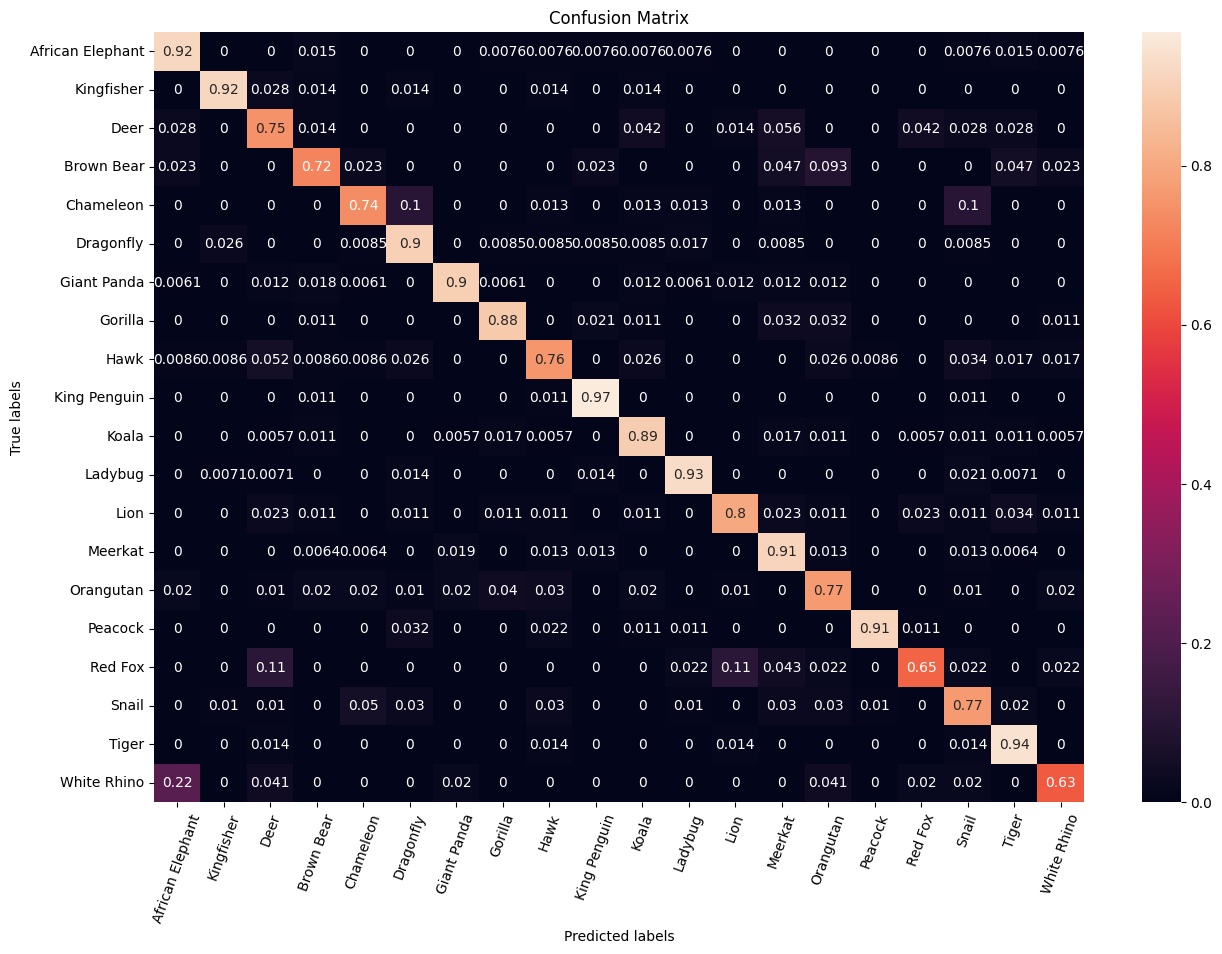

Predicted label ['Brown Bear' 'Snail' 'Meerkat' 'Koala' 'Red Fox' 'Snail' 'Brown Bear'
 'Tiger' 'Snail']
True label ['Giant Panda' 'Orangutan' 'Gorilla' 'Dragonfly' 'Deer' 'Dragonfly'
 'Giant Panda' 'African Elephant' 'Koala']
Corresponding images are shown below


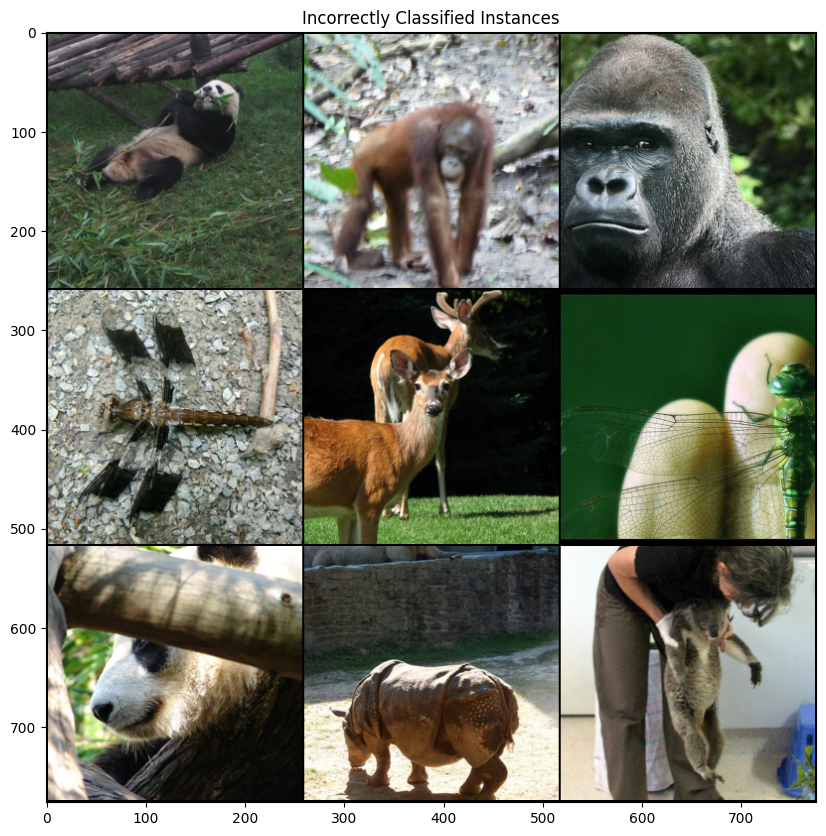

In [81]:
# define and train the network

# Creating the model with the ResNet18
#model = MyResNet()

# Creating the model with the ResNet34
model=MyResNet34()

# original optimizer with 0.0001 learning rate and weight decay 1e-7
#optimizer = optim.Adamax(model.parameters(), lr=0.0001, weight_decay=1e-7)
# optimizer with  rate 0.001
#optimizer = optim.Adamax(model.parameters(), lr=0.001, weight_decay=1e-7)
# optimizer with  learning rate 0.01
#optimizer = optim.Adamax(model.parameters(), lr=0.01, weight_decay=1e-7)
# optimizer with learning rate 0.001 and weight decay 1e-5
#optimizer = optim.Adamax(model.parameters(), lr=0.001, weight_decay=1e-5)
# optimizer with learning rate 0.001 and weight decay 1e-2
#optimizer = optim.Adamax(model.parameters(), lr=0.001, weight_decay=1e-2)


# Final Optimizer:optimizer with learning rate 0.001 and weight decay 1e-5
optimizer = optim.Adamax(model.parameters(), lr=0.001, weight_decay=1e-5)

params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters is: {}".format(params))

# original training with 10 epochs 
#train_part(model, optimizer, epochs = 10)
# training with 30 epochs
#train_part(model, optimizer, epochs = 30)
# training with 50 epochs
#train_part(model, optimizer, epochs = 50)

# training with 40 epochs (final and best training)
train_part(model, optimizer, epochs = 40)


# report test set accuracy
check_accuracy(loader_val, model, analysis=True)


# save the model
torch.save(model.state_dict(), 'model.pt')

---

<!-- BEGIN QUESTION -->

### Network Performance

Run the code below when all engineering decisions have been made, do not overfit to the test set!

**Note that** this will appear in the output, and be checked by markers (so ensure it is present in the auto-export)

Got 1671 / 2000 correct of val set (83.55)
check acc <class 'torch.Tensor'> <class 'torch.Tensor'>


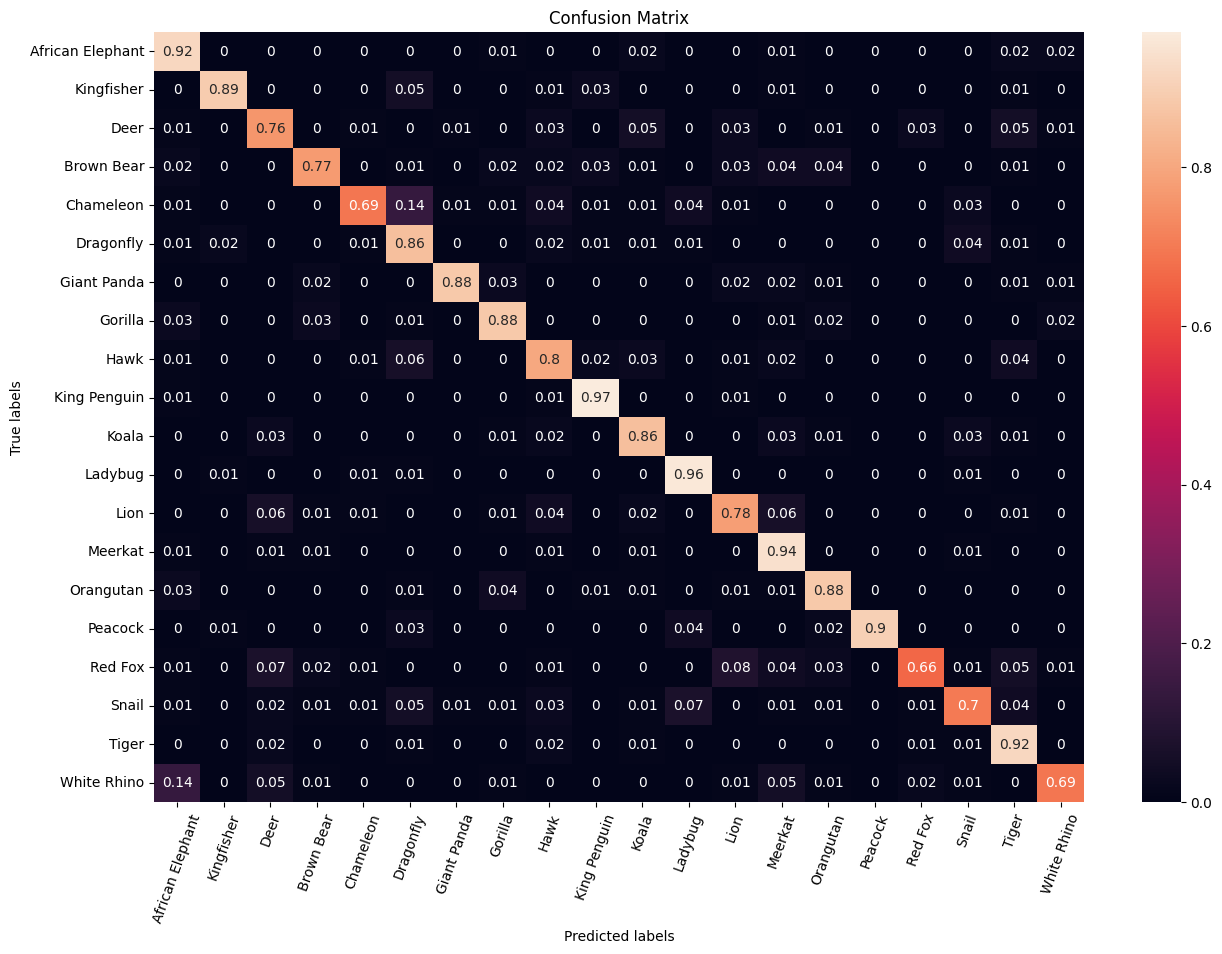

Predicted label ['Snail' 'Deer' 'Hawk' 'Lion' 'Dragonfly' 'Koala' 'Snail' 'Deer' 'Deer']
True label ['Chameleon' 'White Rhino' 'Koala' 'Red Fox' 'Orangutan' 'Dragonfly'
 'Dragonfly' 'Tiger' 'Lion']
Corresponding images are shown below


0.8355

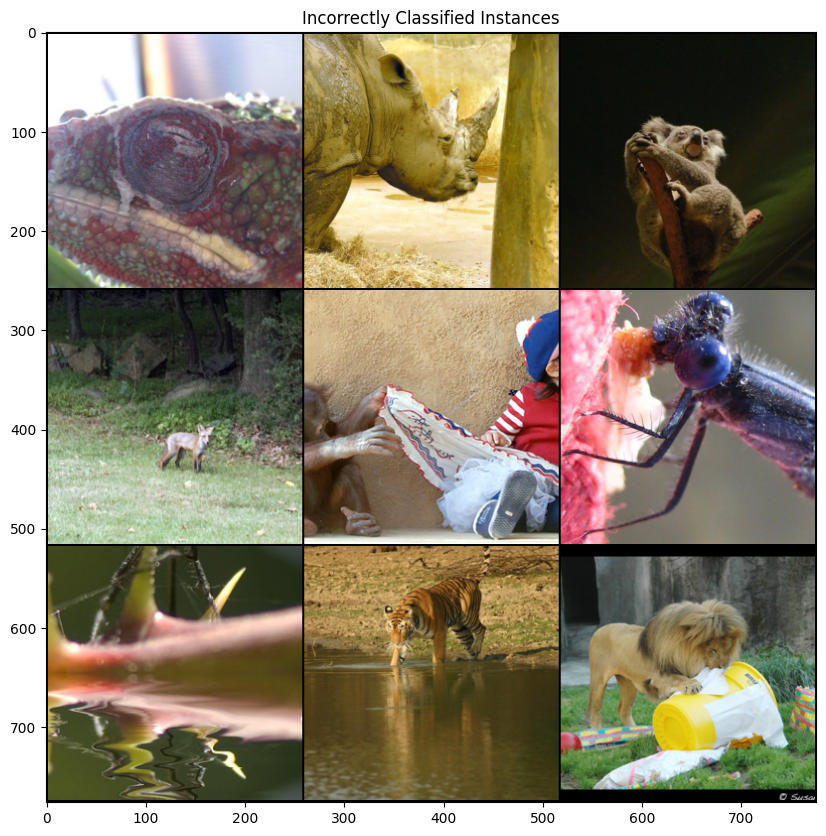

In [82]:
# Run once your have trained your final model
check_accuracy(loader_test, model, analysis=True)

___

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Q2.1: Hyperparameter Search:
Given such a network with a large number of trainable parameters, and a training set of a large number of data, what do you think is the best strategy for hyperparameter searching? (3 points)

**Answer:**

ANSWER HERE:

I believe that traditional strategies like random search, and exhaustive hyperparameter search will be very computationally intensive and
time consuming as the dataset is very big and the hyperparameter space is huge, especially if you think that you can try different
architectures about the restnet and its residual block.
My preferred approach to hyperparameter tuning involves a more investigative and adaptive method. Rather than embarking on an exhaustive 
search from the outset, I adopt a strategy that combines experimentation with logical hypotheses about the model's behavior. 
This approach allows me to efficiently navigate the complex hyperparameter space.
For example doing some logical hypothesis about the model like that "a smaller kernel size may be helpful" is a good strategy as it is based on my
knowledge about the CNN and then through experiments i accept or deny that hypothesis.
So, an individualistic, experimental approach is more desirable as i try out different hyperparameters and i continue experimenting with the best
along the way.


---

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Q2.2: Engineering Decisions

Detail which engineering decisions you made to boost the performance of the baseline results. Why do you think that they helped? (7 points)

**Answer:**

ANSWER HERE

All figures can be found in my google drive file ( https://drive.google.com/file/d/1vKF2modBxvUW51A2H54SNQ6C3U8O-iF6/view?usp=sharing).
As discussed before i followed the investigating approach to boost the performance of my model.

First, i run the basic model which gave me 38% of validation accuracy. I decided to increase the value of learning rate(from 0.0001
to 0.001), which increased the accuracy to 62.5%, so after that i increased it even more to 0.01 which provided a little worse resuls (60%).
This shows that a learnin rate of 0.001 seems to be ideal for this type of network so i continued experimenting with that.
I increased the weight_decay of the optimizer to 1e-5 as when it is larger it provides stronger regularization, and gave me 62% of accuracy.
I decided to increase the number of epochs first to 30 (65.5% of accuracy) and then to 50 which gave me 70% of accuracy as we can see
in figure 1. Then, i decided to try bigger learning rate of 0.01 first for 30 epochs( figure 2) but it did not converge so i run it with
50 epochs (figure 3) but as it can be seen the validaiton accuracy bounces so this learning rate is very big, bounces between local optimal
and not local optimal ponts so the learning rate of 0.001 is better and as seen in figure 1 and it is converged in 40 epochs. 
From now on i run all the experiments with 40 epochs.
I made the weight_decay bigger (1e-2) as can be seen in figure 4 but it produced worse results.
After that, i changed the architecture of the resnet block. I used the Pre-activation Residual block
which starts with a batch normalization as this may help the representation of my data, but the results were a little bit worse with
weight_decay of of 1e-2 and 1e-5 as showed in figure 5 and 6 respectively. I also, added a bias in the residual block but it did not
produce as good results (64%), so i continued with the original residual block, as it provides the best results.
After all these different experiments, i decided to shift my methodology a little bit and use resnet34 as it is a deeper neural network
and it will be able to learn more and i kept my optimal hyperparameters from resnet18.
Resnet34's main differences are that the initial convolution layer has kernel size of 7 instead of 3 and stride of 2 and padding 3.
Has 4 residual layers starting with number of channels 64 and it has 3,4,6,3 residual blocks for each layer respectively and the first layer
has stride of 1 and the rest have stride of size 2. 
After all the layers an average adaptive pooling is followed and then a fully connected layer is used to make the prediction.
I believe the resnet34 is more ideal as its increased depth allows the network to learn a hierarchy of features 
from simple to complex. Each layer captures different levels of abstraction in the data, enabling the model to understand 
fine-grained details as well as high-level features. Also, i am certain average adapting pooling will be helpful as 
it reduces the spatial dimensions of the feature maps while preserving important features,enforces spatial invariance which is
needed in our dataset (as they are images) and the model's predictions are less sensitive to small translations or distortions
in the input image. The most important advantage of it is that it prevents overfitting by reducing the number of parameters 
in the final layers of the network, making it to better generalize on new unseen data.

It achieved 75% of accuracy as seen in Figure 7, so it is a very promising network.
I increased its learning rate to 0.01 but achieved worse results (65%), and with a smaller learning rate (0.0001) and more epochs and
achieved worse results too. So, 0.001 learning rate is perfect for this network too. 
I decided to modify the resnet34 architecture and i removed its maxpooling from the initial convolution layer but it had worse results(68%)
as it did not get the most significant, strong pixel parts of the image in the beginning. Then, i tried an initial kernel of size 3
as it may be able to get more specific details of the pictures but gave me worse results (67%), as the fact that it is a deeper
network is enough to extract more details and it does not need a smaller kernel as networks with less layers do.
Furthermore, i tried the initial resnet(ResNet 18) with a kernel size of 5  but got worse results (63%), for the same reason as before, and i
added a maxPooling in its initial convolution and while it was better than the initial resnet18 it was worse than resnet34 as shown
in figure 8.
In addition, i changed the number of layers of my best model, resnet34, from 4 to 5 which produced a little worse results (72%) 
and to 3 which was a lot worse as seen in figure 9. For 3 layers it seems to being overfitted to the training data(as the training loss
is very low),and cannot actually generalize well which is the reason for getting worse after 22 epochs as displayed in Figure 9.

Finally, i run again the best model of initial resnet34, with 40 epochs, learning rate of 0.001 and weight_decay of 1e-5 and converged
at around 80%-85% accuracy in the validation set as seen in figure 10, which shows again that this is the best model i found throughout
this coursework.








---

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Q2.3: Out of distribution evaluation

Lets see how your trained model performs when evaluated on cartoons of the 20 animal classes. Do not try and modify your model to perform well on this task, this is just a reflective exercise. How did your model perform at the task? Why do you think this was the case? Detail one method which you expect would improve model performance. (2 points)

In [83]:
ON_COLAB = False

!wget https://zenodo.org/records/10424022/files/cartoons.zip?download=1

if ON_COLAB:
    !unzip /content/cartoons.zip?download=1 > /dev/null

else:
    !unzip cartoons.zip?download=1 > /dev/null

--2024-01-30 22:51:53--  https://zenodo.org/records/10424022/files/cartoons.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.185.79.172, 188.184.103.159, 188.184.98.238, ...
Connecting to zenodo.org (zenodo.org)|188.185.79.172|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1737267 (1.7M) [application/octet-stream]
Saving to: ‘cartoons.zip?download=1’

cartoons.zip?downlo 100%[===================>]   1.66M  2.65MB/s    in 0.6s    

2024-01-30 22:51:54 (2.65 MB/s) - ‘cartoons.zip?download=1’ saved [1737267/1737267]



In [85]:
mean = torch.Tensor([0.485, 0.456, 0.406]) # assuming same dist as imagenet
std = torch.Tensor([0.229, 0.224, 0.225])
transform = transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(256),
            transforms.ToTensor(),
            transforms.Normalize(mean.tolist(), std.tolist()),
        ]

    )
cartoon_path = ('/content/' if ON_COLAB else '') + 'cartoons'


cartoon_dataset = datasets.ImageFolder(cartoon_path, transform=transform)

print(len(cartoon_dataset))

batch_size = 128

cartoon_loader = DataLoader(cartoon_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

400


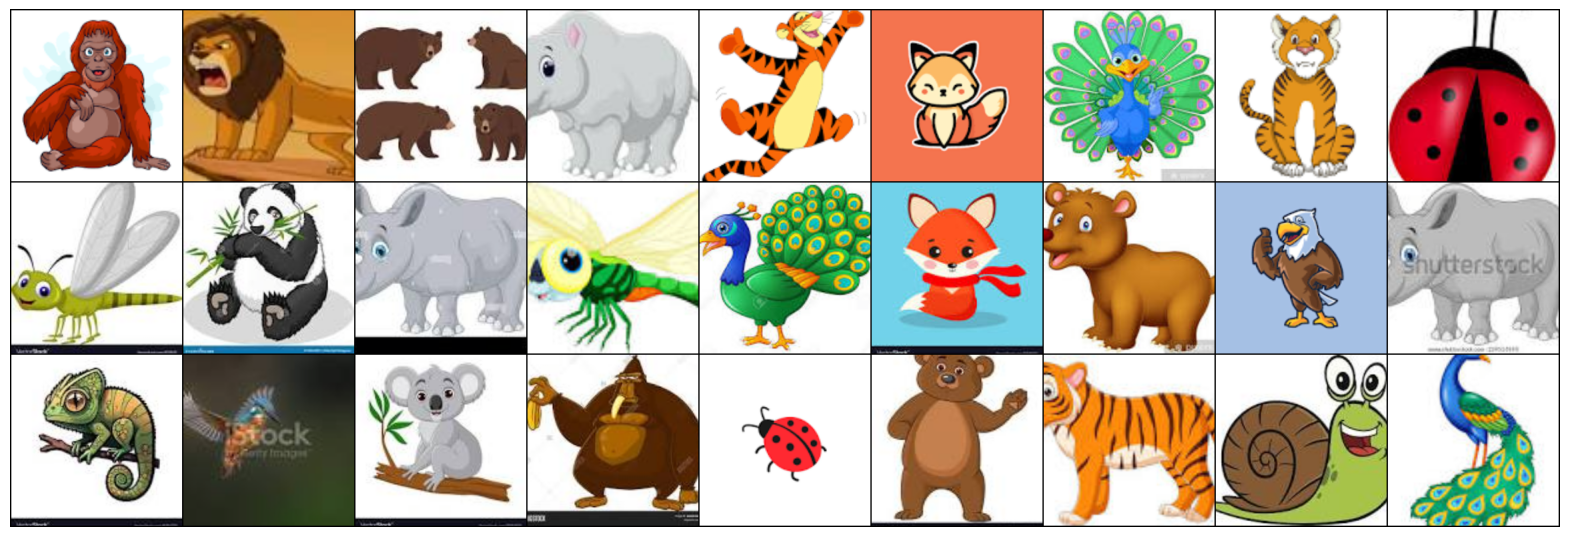

In [86]:
sample_inputs, _ = next(iter(cartoon_loader))
fixed_input = sample_inputs[:27, :, :, :]

img = make_grid(denorm(fixed_input), nrow=9, padding=2, normalize=False,
                value_range=None, scale_each=False, pad_value=0)

plt.figure(figsize=(20,10))
plt.axis('off')
show(img)

Got 147 / 400 correct of val set (36.75)
check acc <class 'torch.Tensor'> <class 'torch.Tensor'>


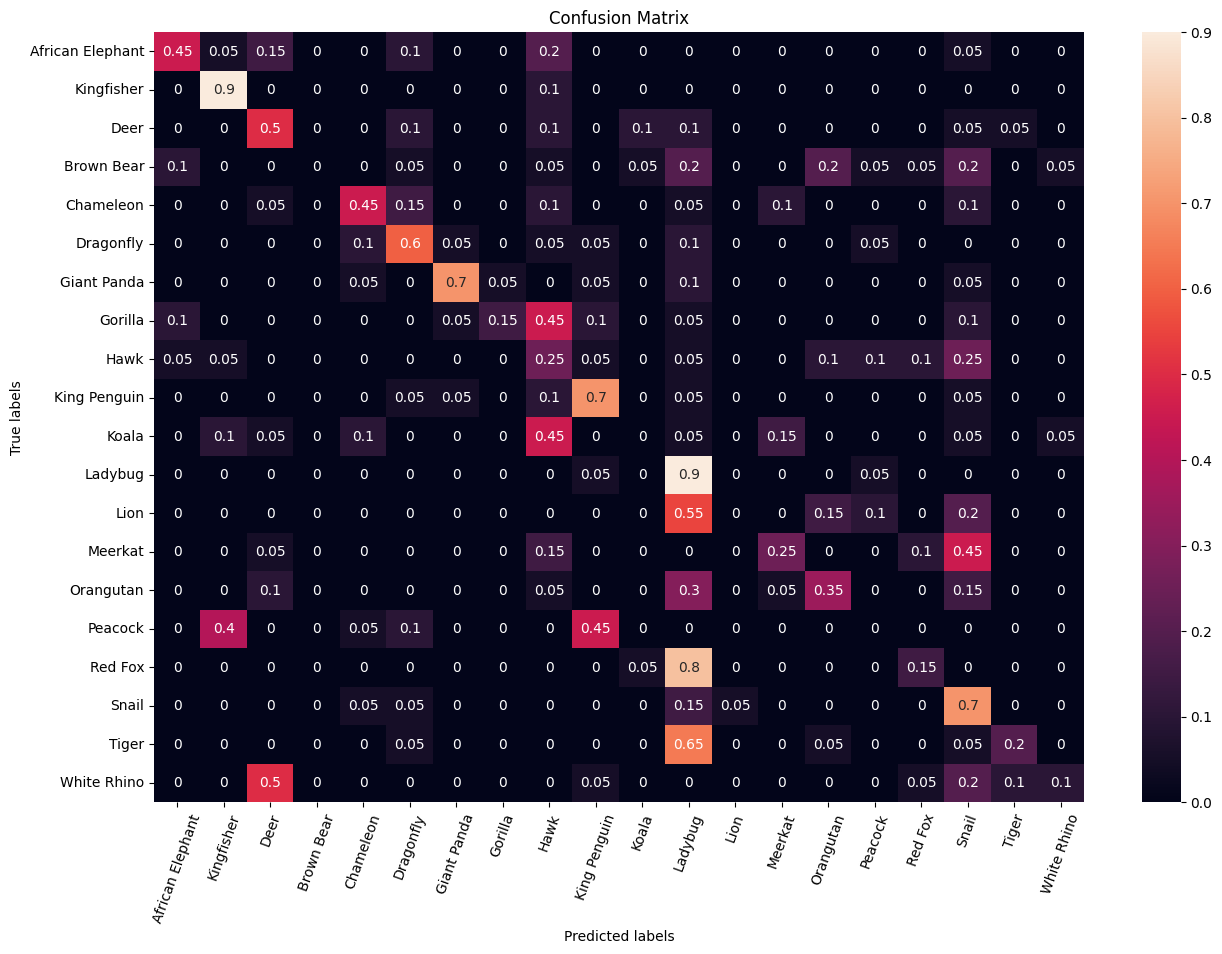

Predicted label ['Dragonfly' 'Dragonfly' 'Red Fox' 'Snail' 'Dragonfly' 'King Penguin'
 'Ladybug' 'Hawk']
True label ['Chameleon' 'Chameleon' 'White Rhino' 'Brown Bear' 'African Elephant'
 'Peacock' 'Red Fox' 'Koala']
Corresponding images are shown below


0.3675

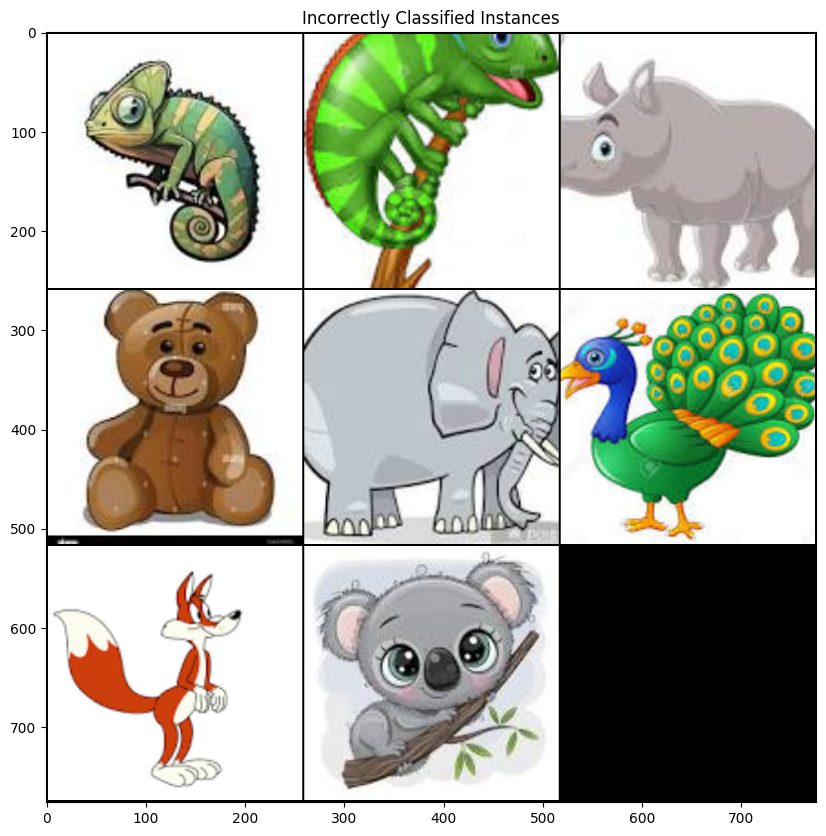

In [87]:
check_accuracy(cartoon_loader, model, analysis=True)

**Answer:**

ANSWER HERE

My model did not perform well in the cartoon dataset , it reduced the accuracy to 36%. 
I think this is the case as my training set contains only real life images of animals which differ a lot with the 
animated pictures. The two datasets have differ in their visual characteristics sto my model cannot capture the
animated animals so well as it does in the real ones.The cartoon images differ from the real as their features are exaggerated 
and have simplified shapes with a disctinct color scheme. 
To improve performance i should use a training set which contains both real and cartoon images, to help the CNN 
generalize on both types of images. Also, other domain adaptation techniques may be useful to boost the performance.



<!-- END QUESTION -->

## Part 3 (10 points)

The code provided below will allow you to visualise the feature maps computed by different layers of your network. Run the code (install matplotlib if necessary) and **answer the following questions*(:

<!-- BEGIN QUESTION -->

### Q3.1 : Learned Features

Compare the feature maps from low-level layers to high-level layers, what do you observe? (4 points)

**Answer:**

ANSWER HERE

Comparing the feature maps, i observe that in the initial layers it
captures more generic features than the higher layers. For example, low level layers capture basic features like textures, colors, edges.
As you move deeper, the complexity of the features increases and detects more complex strucctures in comparison to the initial layers which
detect more simple structures. Also, low level layers have higher spatial resolution as they are closer to the original input image. On 
the other hand, high level layers have reduced spatial resolution as they lose information throughout the pooling operations and focus
on capturing the essence of the features.


---

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Q3.2: Performance Analysis

Use the training log, reported test set accuracy and the feature maps, analyse the performance of your network. If you think the performance is sufficiently good, explain why; if not, what might be the problem and how can you improve the performance? (4 points)

**Answer:**

ANSWER HERE

I think the performance of my network is very good. From the training log, i can see that the network converges in both the training
and validation test in a very good result and it is not being overfitted as the validation accuracy is 80%. Also, in the graph
i showed previously(Figure 10) it shows that the network converges and generalizes well.
Also, it is generally very good as it achieves great results in the test data, it achieves similar results to the validation set
(83% accuracy).
This is important as it performs so well in fully unseen data, that never saw before and there was not hyperparameter tuning in those
data, so the network generalizes very well in unseen data which is the main target for machine learning models.
From the confusion matrix, i can see that all classes accuracy is over 70% except the white rino (63%) and the red fox(65%)
which is really good as the total number of different classes is 20. Finally, from the incorrectly classified image i can see
that it does not classify well pictures that show the animal from an unusual angle, or there are more animals, or the picture is blurry,
or the animal is covered by another object (bamboo). So, it shows that these pictures actually make sense to be misclassified as
the animal cannot be seen easily and maybe even a person cannot classify the animal in some of these images.
Of course, the model can be improved but it would be computationally intensive and i fear that it would maybe overfit in the training
and validation set and would not be able to generalize and be successful in fully unseen data (test data).

---

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Q3.3: Alternative Evaluations

What are the other possible ways to analyse the performance of your network? (2 points)

**Answer:**

ANSWER HERE
There are many possible ways to analyse the performance of my network like using k-cross validation to reduce the impact of the 
specific division of data. Also, i can use other performance metrics alongside the accuracy, like the F1-score to check 
if the model is biased towards a specific class and do a data augmentation analysis to analyze how the model performs 
with augmented data (rotated, scaled data).

---

<!-- END QUESTION -->

**Feature Visualization**

The code below will visualize the features of your network layers (you may need to modify the layer names if you made changes to your architecture).

If you change the plotting code, please ensure it still exports correctly when running the submission cell.

In [90]:
import matplotlib.pyplot as plt

def plot_model_features():
    fig = plt.tight_layout()
    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook
    #vis_labels = ['conv1', 'layer1', 'layer2', 'layer3', 'layer4', 'layer5', 'layer6']
    vis_labels = ['conv1', 'layer1', 'layer2', 'layer3', 'layer4']

    for l in vis_labels:
        getattr(model, l).register_forward_hook(get_activation(l))


    data, _ = test_dataset[999]
    data = data.unsqueeze_(0).to(device = device, dtype = dtype)
    output = model(data)

    for idx, l in enumerate(vis_labels):
        act = activation[l].squeeze()

        # only showing the first 16 channels
        ncols, nrows = 8, 2

        fig, axarr = plt.subplots(nrows, ncols, figsize=(15,5))
        fig.suptitle(l)

        count = 0
        for i in range(nrows):
            for j in range(ncols):
                axarr[i, j].imshow(act[count].cpu())
                axarr[i, j].axis('off')
                count += 1

<!-- BEGIN QUESTION -->



<Figure size 640x480 with 0 Axes>

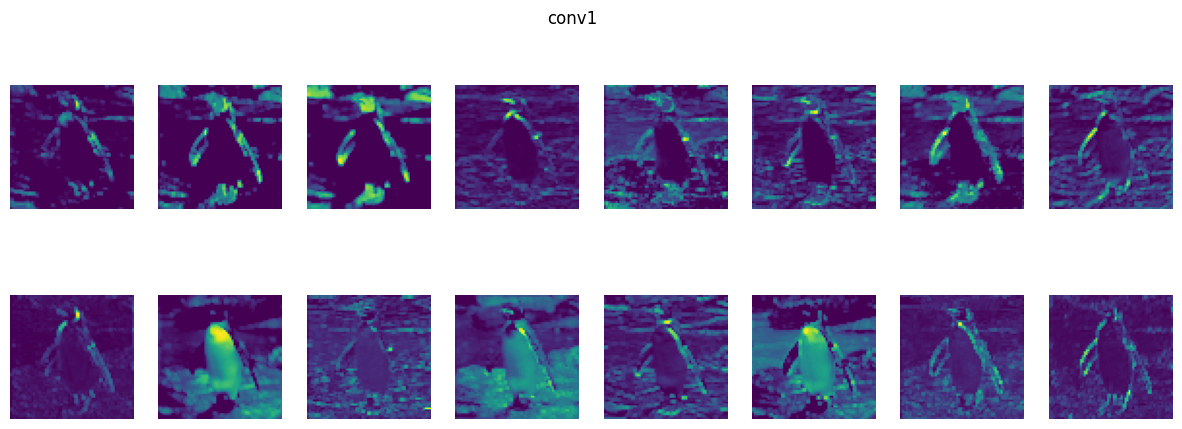

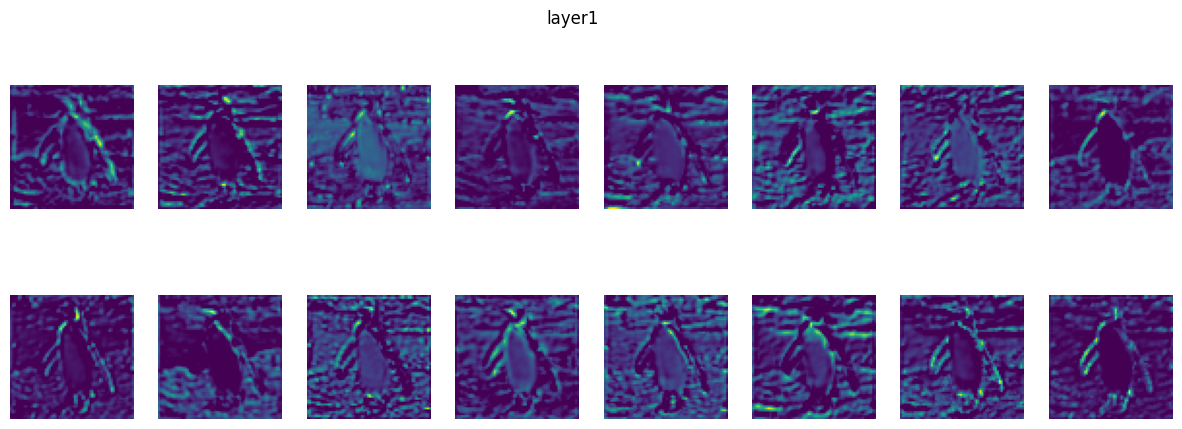

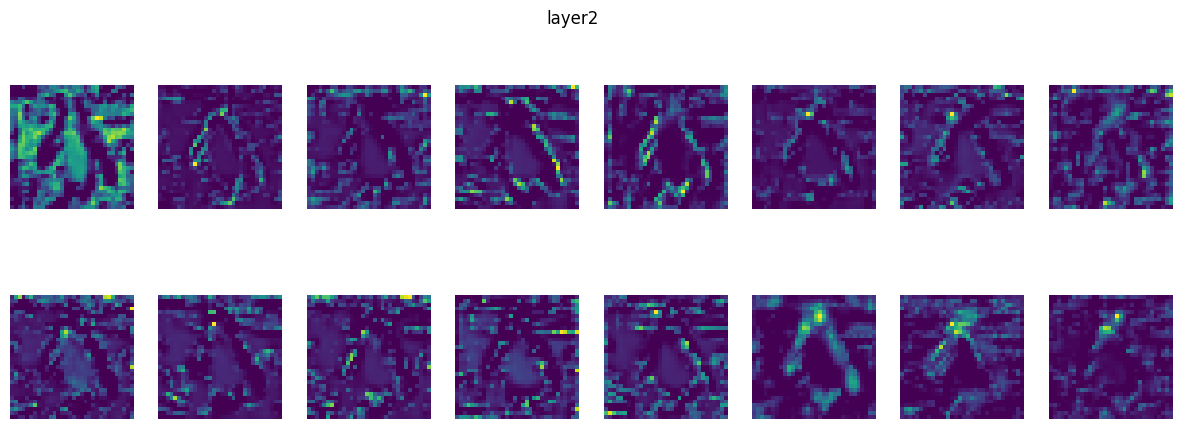

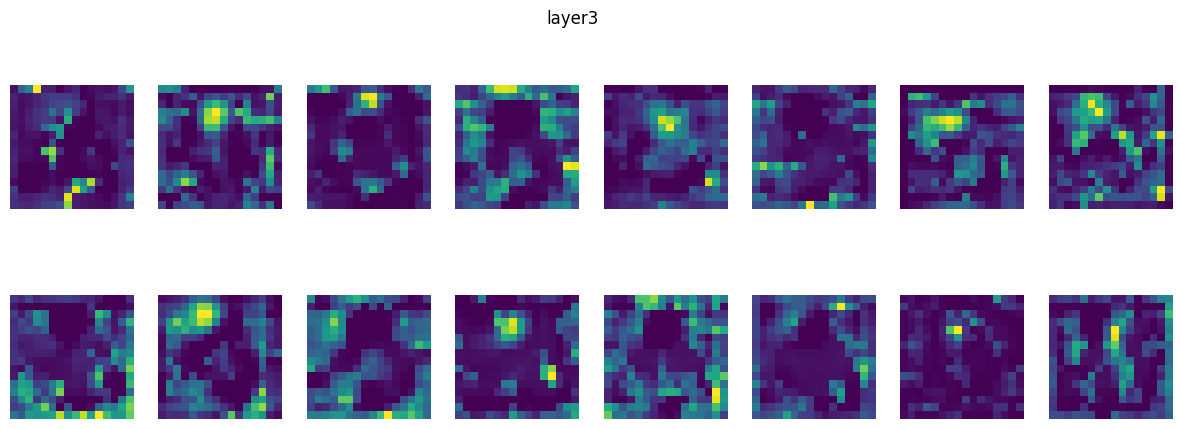

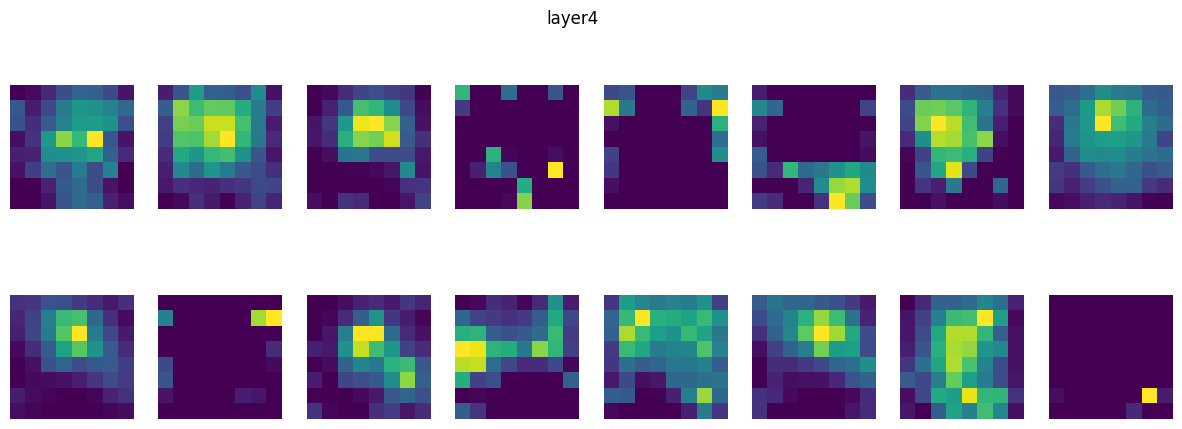

In [91]:
# Visualize the figure here, so it is exported nicely
plot_model_features()

<!-- END QUESTION -->

## Submission
Git push your finalized version of this notebook (with saved outputs) to the gitlab repo which you were assigned. You should request our tests once and check that the ```preview.pdf```:
* Passes all public tests (these are the same ones provided / embedded in the notebook itself)
* Contains your qualitative answers
* Contains your figures (confusion matrix and network features)

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [100]:
grader.check_all()

BatchNorm Layer results: All test cases passed!
BatchNorm Layer - 1 message: Shape Test Passed
BatchNorm Layer - 2 message: Type Test Passed
BatchNorm Layer - 3 message: Param Name Test Passed
BatchNorm Layer - 4 message: Param Shape Test Passed

Convolution Layer results: All test cases passed!
Convolution Layer - 1 message: Shape Test Passed
Convolution Layer - 2 message: Type Test Passed
Convolution Layer - 3 message: Param Name Test Passed
Convolution Layer - 4 message: Param Shape Test Passed

Linear Layer results: All test cases passed!
Linear Layer - 1 message: Shape Test Passed
Linear Layer - 2 message: Type Test Passed
Linear Layer - 3 message: Param Name Test Passed
Linear Layer - 4 message: Param Shape Test Passed

MaxPool Layer results: All test cases passed!
MaxPool Layer - 1 message: Shape Test Passed
MaxPool Layer - 2 message: Type Test Passed